## Imports

In [1]:
import jupyter_black

import sys
import numpy as np
import matplotlib.pyplot as plt

jupyter_black.load()


if "/usr/src" not in sys.path:
    sys.path.append("/usr/src")

In [2]:
# Import torch modules

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

In [3]:
# Import custom modules

import utils
import data.prepare_cells as pc

from model.vae import VAE, ConvolutionalVAE
from model.helper_train import train

## Settings

In [54]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0005
NUM_EPOCHS = 200
BATCH_SIZE = 64
IMAGE_SIZE = 56
LATENT_SIZE = 4
RECONSTRUCTION_TERM_WEIGHT = 1

## Dataset

In [5]:
# Directory with source data

cells_dir = "/usr/src/data/bacterias/separated_cells"

transform = transforms.Compose(
    [transforms.ToPILImage(), pc.CellPadResize(56), transforms.ToTensor()]
)

dataset = pc.CellsImageDataset(cells_dir, transform=transform)

test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
print("Train sample's size =", train_size)
print("Test sample's size =", test_size)

Train sample's size = 1528
Test sample's size = 382


In [6]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Checking the dataset
print("Training Set:")
for images in train_loader:
    print("Image batch dimensions:", images.size())
    break

# Checking the dataset
print("\nTesting Set:")
for images in test_loader:
    print("Image batch dimensions:", images.size())
    break

Training Set:
Image batch dimensions: torch.Size([64, 1, 56, 56])

Testing Set:
Image batch dimensions: torch.Size([64, 1, 56, 56])


## Creating and training Model
(VAE with linear layers)

In [ ]:
utils.set_all_seeds(RANDOM_SEED)

model = VAE(DEVICE, IMAGE_SIZE, LATENT_SIZE)
model.to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
log_dict = train(NUM_EPOCHS, model, optimizer, DEVICE, train_loader, logging_interval=6)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
losses = [
    "train_combined_loss_per_batch",
    "train_reconstruction_loss_per_batch",
    "train_kl_loss_per_batch",
]

for ax, loss in zip(axes, losses):
    ax.plot(log_dict[loss])
    ax.set(title=loss, xlabel="Iterations", ylabel="Loss")

In [ ]:
n_images = 10

fig, axes = plt.subplots(2, n_images, sharex=True, sharey=True, figsize=(20, 2.5))

features = next(iter(train_loader))
features = features.to(DEVICE)
color_channels = features.shape[1]
image_height = features.shape[2]
image_width = features.shape[3]

with torch.no_grad():
    encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
orig_images = features[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device("cpu"))
        if color_channels > 1:
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax[i].imshow(curr_img)
        else:
            ax[i].imshow(curr_img.view((image_height, image_width)), cmap="gray")

In [ ]:
some_batch = next(iter(test_loader)).to(DEVICE)
with torch.no_grad():
    encoded, z_mean, z_log_var, decoded_images = model(some_batch)
print(some_batch.shape, decoded_images.shape)

In [ ]:
first_orig = some_batch[0]
first_decoded = decoded_images[0]
utils.show_image(first_orig.detach().to(torch.device("cpu")))
utils.show_image(first_decoded.detach().to(torch.device("cpu")))

In [ ]:
n_images = 10

with torch.no_grad():
    rand_features = torch.randn(n_images, 4).to(DEVICE)
    generated_images = model.decoder(rand_features)

fig, axes = plt.subplots(1, n_images, figsize=(15, 2))

for ax, image in zip(axes, generated_images):
    ax.imshow(image.detach().to(torch.device("cpu")).reshape(56, 56), cmap="gray")

In [ ]:
sum(p.numel() for p in model.parameters())

## Convolutional VAE

In [43]:
utils.set_all_seeds(RANDOM_SEED)

In [49]:
conv_model_1 = ConvolutionalVAE(DEVICE, IMAGE_SIZE, LATENT_SIZE)
conv_model_1.to(DEVICE)

optimizer_1 = torch.optim.Adam(conv_model_1.parameters(), lr=LEARNING_RATE)


In [89]:
conv_model_2 = ConvolutionalVAE(DEVICE, IMAGE_SIZE, LATENT_SIZE)
conv_model_2.to(DEVICE)

optimizer_2 = torch.optim.Adam(conv_model_2.parameters(), lr=LEARNING_RATE)

In [ ]:
log_dict_1 = train(
    NUM_EPOCHS,
    conv_model_1,
    optimizer_1,
    DEVICE,
    train_loader,
    logging_interval=6,
    reconstruction_term_weight=0.5,
)

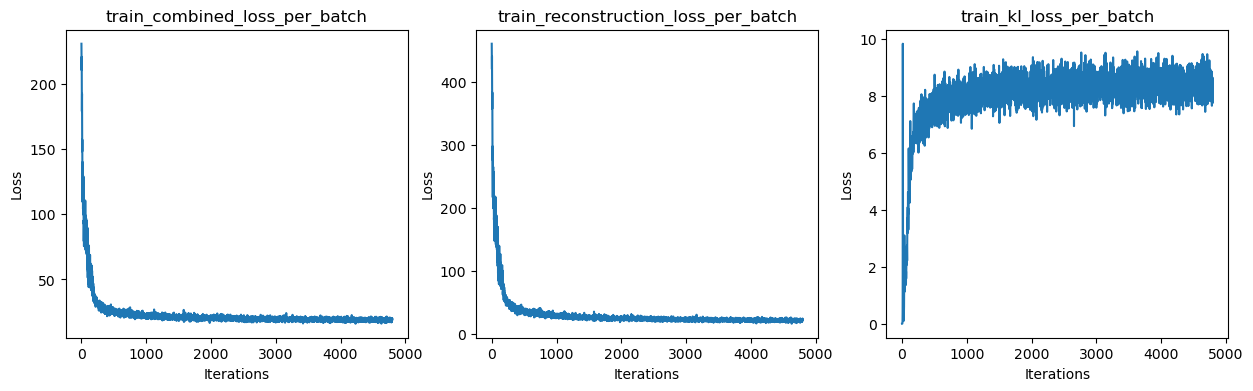

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
losses = [
    "train_combined_loss_per_batch",
    "train_reconstruction_loss_per_batch",
    "train_kl_loss_per_batch",
]

for ax, loss in zip(axes, losses):
    ax.plot(log_dict_1[loss])
    ax.set(title=loss, xlabel="Iterations", ylabel="Loss")

In [90]:
log_dict_2 = train(
    NUM_EPOCHS,
    conv_model_2,
    optimizer_2,
    DEVICE,
    train_loader,
    logging_interval=6,
    reconstruction_term_weight=1,
)

Epoch: 001/200 | Batch 0000/0024 | Loss: 592.0905
Epoch: 001/200 | Batch 0006/0024 | Loss: 573.3124
Epoch: 001/200 | Batch 0012/0024 | Loss: 445.1800
Epoch: 001/200 | Batch 0018/0024 | Loss: 357.8658
Time elapsed: 0.01 min
Epoch: 002/200 | Batch 0000/0024 | Loss: 272.5674
Epoch: 002/200 | Batch 0006/0024 | Loss: 241.9007
Epoch: 002/200 | Batch 0012/0024 | Loss: 167.6480
Epoch: 002/200 | Batch 0018/0024 | Loss: 195.9458
Time elapsed: 0.02 min
Epoch: 003/200 | Batch 0000/0024 | Loss: 220.5436
Epoch: 003/200 | Batch 0006/0024 | Loss: 179.0416
Epoch: 003/200 | Batch 0012/0024 | Loss: 165.7457
Epoch: 003/200 | Batch 0018/0024 | Loss: 146.9138
Time elapsed: 0.04 min
Epoch: 004/200 | Batch 0000/0024 | Loss: 130.7724
Epoch: 004/200 | Batch 0006/0024 | Loss: 152.1191
Epoch: 004/200 | Batch 0012/0024 | Loss: 161.1701
Epoch: 004/200 | Batch 0018/0024 | Loss: 159.5379
Time elapsed: 0.05 min
Epoch: 005/200 | Batch 0000/0024 | Loss: 161.7042
Epoch: 005/200 | Batch 0006/0024 | Loss: 131.9841
Epoch: 0

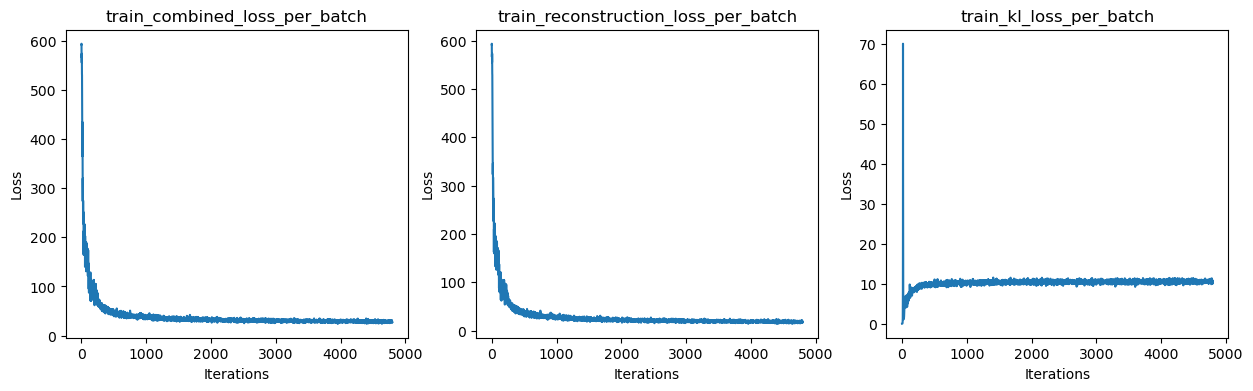

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
losses = [
    "train_combined_loss_per_batch",
    "train_reconstruction_loss_per_batch",
    "train_kl_loss_per_batch",
]

for ax, loss in zip(axes, losses):
    ax.plot(log_dict_2[loss])
    ax.set(title=loss, xlabel="Iterations", ylabel="Loss")

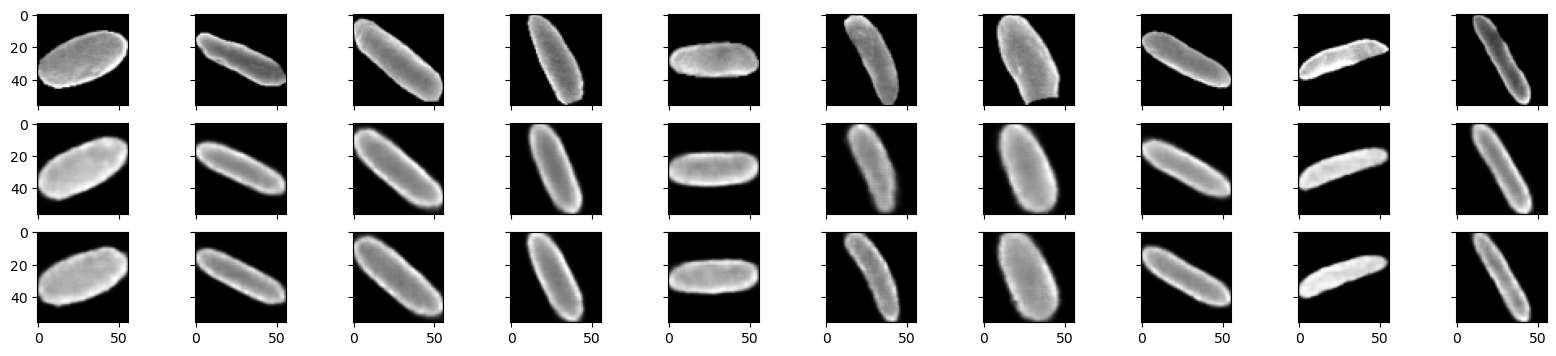

In [94]:
n_images = 10

fig, axes = plt.subplots(3, n_images, sharex=True, sharey=True, figsize=(20, 4))

features = next(iter(train_loader))
features = features.to(DEVICE)
color_channels = features.shape[1]
image_height = features.shape[2]
image_width = features.shape[3]

with torch.no_grad():
    encoded, z_mean, z_log_var, decoded_images = conv_model_1(features)[:n_images]
    encoded_2, z_mean_2, z_log_var_2, decoded_images_2 = conv_model_2(features)[
        :n_images
    ]
orig_images = features[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images, decoded_images_2]):
        curr_img = img[i].detach().to(torch.device("cpu"))
        if color_channels > 1:
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax[i].imshow(curr_img)
        else:
            ax[i].imshow(curr_img.view((image_height, image_width)), cmap="gray")

## Generate new images

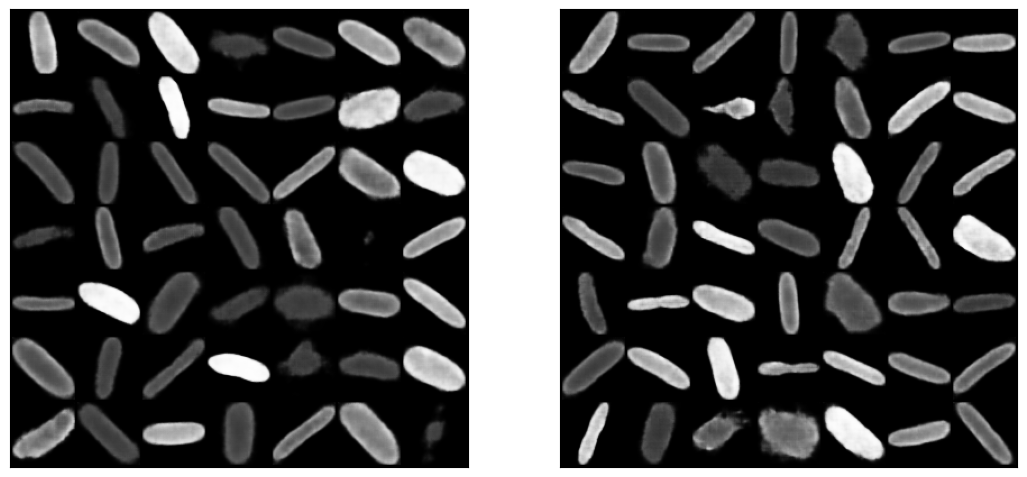

In [108]:
n_images = 49

with torch.no_grad():
    rand_features = torch.randn(n_images, LATENT_SIZE).to(DEVICE)
    generated_images_1 = conv_model_1.decoder(rand_features)
    generated_images_2 = conv_model_2.decoder(rand_features)
    generated_images = [generated_images_1, generated_images_2]

_, ax = plt.subplots(1, 2, figsize=(13, 7))
for i in range(2):
    grid = make_grid(generated_images[i], nrow=int(np.sqrt(n_images)))
    grid = grid.detach().to(torch.device("cpu"))
    grid = np.transpose(grid, (1, 2, 0))
    ax[i].imshow(grid, cmap="gray", vmin=0, vmax=255)
    ax[i].set(xticks=[], yticks=[])
# plt.show()

## Save model

In [85]:
torch.save(conv_model_1, "conv_vae_1.pt")
torch.save(conv_model_2, "conv_vae_2.pt")

In [ ]:
load_model = torch.load('conv_vae.pt')
load_model.eval()